In [15]:
# IMPORTING MODULES
import glob
import heartpy as hp
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.signal as ss
import sys
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")

import tools.data_reader_case as dr
import tools.display_tools as dt
import tools.preprocessing as preprocessing

from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import butter, lfilter

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

In [2]:
# ECG METRICS -- 
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import ecg
import heartpy
import pyhrv
import pyhrv.time_domain as td

# phases = dr.CLIPS
phases = [10]
metric = "bpm"
subjects = dr.SUBJECTS
# subjects = [30]
fs = 1000.0

for phase in phases:
    data = []
    df_dict = {s: dr.read_ecg(s, phase) for s in subjects}
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        
        bpm = preprocessing.get_bpm_biosppy(ecg_signal, fs=fs)

        bpm.insert(0, int(s))
        data.append(bpm)

    file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
    df = pd.DataFrame(data=data)
    df.to_csv(file_name)

In [3]:
# ECG METRICS -- 
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import ecg
import heartpy
import pyhrv
import pyhrv.time_domain as td

# phases = dr.CLIPS
phases = [10]
subjects = dr.SUBJECTS
# subjects = [30]
fs = 1000.0

for phase in phases:
    df_dict = {s: dr.read_ecg(s, phase) for s in subjects}
    metrics_dict = {
        "rmssd": [],
        "sdnn": []
    }
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        # ecg_signal = preprocessing.clean_ecg(ecg_signal).to_numpy().flatten()
        # ecg_signal = hp.enhance_ecg_peaks(ecg_signal, fs)
        # working_data, measures = hp.process_segmentwise(ecg_signal, fs, segment_width=55, segment_overlap=5/55)
        # print(np.isnan(measures["bpm"][0]))
        # print(measures["bpm"][0])
        
        ecg_features = preprocessing.get_ecg_metrics_pyhrv(ecg_signal, fs=fs)
        
        for metric in list(metrics_dict.keys()):
            feature = ecg_features[metric]
            feature.insert(0, int(s))
            metrics_dict[metric].append(feature)

    for metric in list(metrics_dict.keys()):
        df = pd.DataFrame(metrics_dict[metric])
        metrics_dict[metric] = df
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

In [4]:
# HF and LF metrics -- DONE
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

from biosppy.signals import ecg
import samplerate


# phases = dr.CLIPS
phases = [10]
subjects = dr.SUBJECTS
fs = 1000.0

for phase in phases:
    print(f"Clip {phase}")
    df_dict = {s: dr.read_ecg(s, phase) for s in subjects}
    metrics_dict = {
        "lf_rr": [],
        "hf_rr": [],
    }
    for s in list(df_dict.keys()):
        df = df_dict[s]
        ecg_signal = df.iloc[:, -1]
        # samplerate.resample(ecg_signal, ratio=250.0 / 1000.0)
        out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
        ecg_signal = out["filtered"]
        lf_rr = preprocessing.get_lf_rr(ecg_signal, fs)
        lf_rr = np.insert(lf_rr, 0, s)
        lf_rr = pd.DataFrame(lf_rr).dropna(axis=1)

        hf_rr = preprocessing.get_hf_rr(ecg_signal, fs)
        hf_rr = np.insert(hf_rr, 0, s)
        hf_rr = pd.DataFrame(hf_rr).dropna(axis=1)

        metrics_dict["lf_rr"].append(lf_rr)
        metrics_dict["hf_rr"].append(hf_rr)

    for metric in list(metrics_dict.keys()):
        df = pd.concat(metrics_dict[metric], axis=1)
        df = df.transpose()
        metrics_dict[metric] = df
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

Clip 10


In [4]:
# FEATURE EXTRACTION - EDA -- DONE
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from heartpy.preprocessing import scale_data
import samplerate
from biosppy.signals import eda


phases = dr.CLIPS
# phases = [10]
subjects = dr.SUBJECTS
# subjects = [1, 2, 16, 30]
# fs = 1000.0
fs = 250.0

for phase in phases:
    print(f"Clip {phase}")
    df_dict = {s: dr.read_gsr(s, phase) for s in subjects}
    metrics_dict = {
        "mean_SCL": [],
        "SCR_rate": [],
    }
    for s in list(df_dict.keys()):
        print(f"{s} " + "-"*20)
        df = df_dict[s]
        eda_signal = df.iloc[:, -1]
        eda_signal = samplerate.resample(eda_signal, ratio=250.0 / 1000.0)
        eda_signal = scale_data(eda_signal)
        try:
            out = eda.eda(signal=eda_signal, sampling_rate=fs, show=False)
            eda_signal = out["filtered"]
        except Exception as e:
            print(e)
            print(f"Error cleaning data for {s}")

        mean_scl = preprocessing.get_mean_SCL(eda_signal, fs)
        mean_scl = np.insert(mean_scl, 0, s)
        mean_scl = pd.DataFrame(mean_scl).dropna(axis=1)

        scr_rate = preprocessing.get_SCR_rate(eda_signal, fs)
        scr_rate = np.insert(scr_rate, 0, s)
        scr_rate = pd.DataFrame(scr_rate).dropna(axis=1)

        # print(f"mean SCL:\n{mean_scl}\nSCR rate:\n{scr_rate}")

        metrics_dict["mean_SCL"].append(mean_scl)
        metrics_dict["SCR_rate"].append(scr_rate)

    for metric in list(metrics_dict.keys()):
        df = pd.concat(metrics_dict[metric], axis=1)
        df = df.transpose()
        metrics_dict[metric] = df
        
    for metric in list(metrics_dict.keys()):
        file_name = os.path.join(dr.Paths.METRICS, f"{metric}_{phase}.csv")
        metrics_dict[metric].to_csv(file_name)

Clip 1
1 --------------------
index -1 is out of bounds for axis 0 with size 0
Error cleaning data for 1
2 --------------------
3 --------------------
4 --------------------
5 --------------------
6 --------------------
7 --------------------
8 --------------------
9 --------------------
10 --------------------
11 --------------------
12 --------------------
13 --------------------
14 --------------------
15 --------------------
16 --------------------
17 --------------------
18 --------------------
19 --------------------
20 --------------------
21 --------------------
22 --------------------
23 --------------------
24 --------------------
25 --------------------
26 --------------------
27 --------------------
28 --------------------
29 --------------------
30 --------------------
Clip 2
1 --------------------
2 --------------------
3 --------------------
4 --------------------
5 --------------------
6 --------------------
7 --------------------
8 --------------------
9 --------------

In [17]:
# FEATURE EXTRACTION: STATISTICAL FEATURES -- DONE
# mean, median, std, variance, IQR, RMS, skewness, kurtosis
importlib.reload(dr)
importlib.reload(dt)
importlib.reload(preprocessing)

import biosppy
from biosppy.signals import eda
from biosppy.signals import ecg
from scipy.stats import iqr, skew, kurtosis

from heartpy.preprocessing import scale_data


def rms(x):
    return np.sqrt(np.mean(x**2))

metrics = {
    "mean": np.nanmean,
    "median": np.nanmedian,
    "std": np.nanstd,
    "var": np.nanvar,
    "iqr": iqr,
    "rms": rms,
    "skew": skew,
    "kurtosis": kurtosis
}

phases = dr.CLIPS
# phases = [10]
subjects = dr.SUBJECTS
fs = 1000.0

order = 3
cutoff = 5
b, a = butter(order, cutoff, fs=fs, btype='low', analog=False)

# for phase in phases:
#     print(f"Clip {phase}")
#     data = {metric: [] for metric in metrics.keys()}
#     df_dict = {s: dr.read_ecg(s, phase) for s in subjects}
#     for s in list(df_dict.keys()):
#         df = df_dict[s]
#         ecg_signal = df.iloc[:, -1].reset_index(drop=True)
#         ecg_signal = scale_data(ecg_signal)
        # data = hp.filtering.remove_baseline_wander(data, fs)
#         out = ecg.ecg(signal=ecg_signal, sampling_rate=fs, show=False)
#         ecg_signal = out["filtered"]
#         # filtered = lfilter(b, a, eda_signal)

#         for metric in metrics.keys():
#             value = preprocessing.get_statistical_metrics(ecg_signal, metrics[metric], fs)
#             value = np.insert(value, 0, s)
#             data[metric].append(value)

#     for metric in metrics.keys():
#         file_name = os.path.join(dr.Paths.METRICS, f"ecg_{metric}_{phase}.csv")
#         df = pd.DataFrame(data=data[metric])
#         df.to_csv(file_name)

for phase in phases:
    print(f"Clip {phase}")
    data = {metric: [] for metric in metrics.keys()}
    df_dict = {s: dr.read_gsr(s, phase) for s in subjects}
    for s in list(df_dict.keys()):
        df = df_dict[s]
        eda_signal = df.iloc[:, -1].reset_index(drop=True)
        sos = butter(N=3, Wn=4.0, btype="lowpass", fs=fs, output="sos")
        data = ss.sosfilt(sos, eda_signal)
        print(data.shape)
        data = scale_data(data)
        print(data.shape)
        out = eda.eda(signal=data, sampling_rate=fs, show=False)
        data = out["filtered"]
        # try:
        #     out = eda.eda(signal=eda_signal, sampling_rate=fs, show=False, min_amplitude=0.01)
        #     eda_signal = out["filtered"]
        # except Exception as e:
        #     print(f"Error cleaning data for {s}")
        
        # filtered = lfilter(b, a, eda_signal)
        for metric in metrics.keys():
            value = preprocessing.get_statistical_metrics(eda_signal, metrics[metric], fs)
            value = np.insert(value, 0, s)
            data[metric].append(value)

    for metric in metrics.keys():
        file_name = os.path.join(dr.Paths.METRICS, f"eda_{metric}_{phase}.csv")
        df = pd.DataFrame(data=data[metric])
        df.to_csv(file_name)

Clip 1
(185583,)
(185583,)


IndexError: index -1 is out of bounds for axis 0 with size 0

TypeError: 'value' must be an instance of str or bytes, not a int

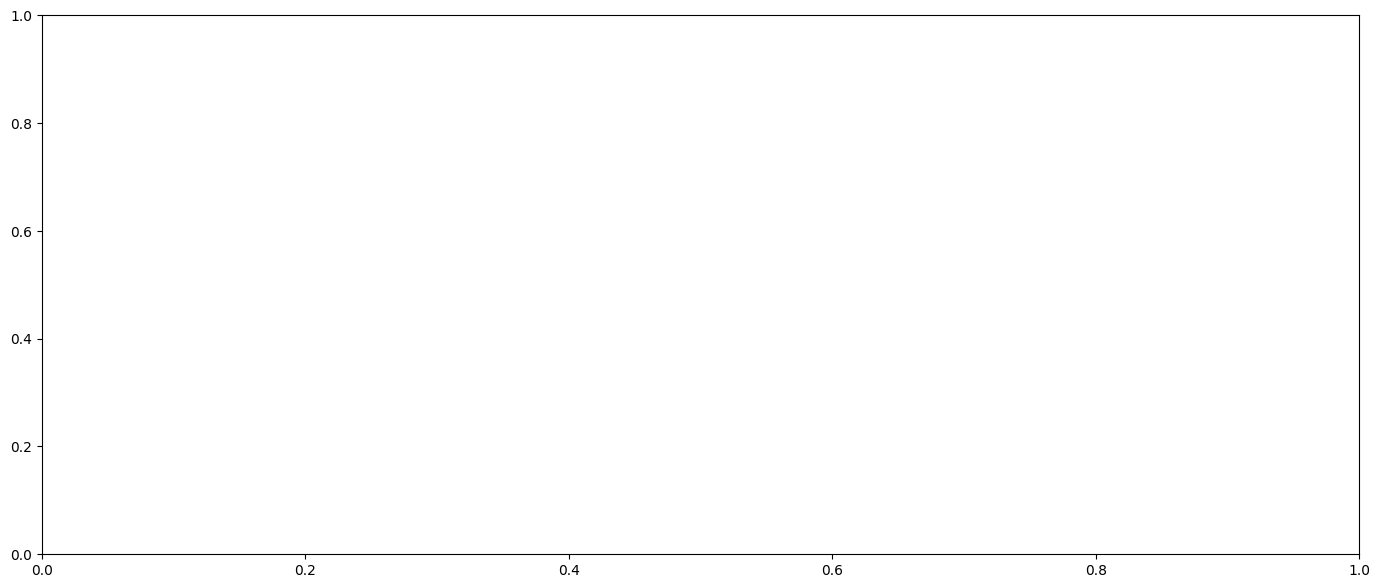

In [19]:
phases = dr.CLIPS
subjects = dr.SUBJECTS

df_dict = {s: dr.read_gsr(s, phases[0]) for s in subjects}

dt.plot_1d_data(df_dict[subjects[0]].to_numpy())